In [1]:
%load_ext autoreload
%autoreload 2

# Human Tonsil (CytAssist)

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import sys 
import commot as ct

sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions
# from spaceoracle.tools.network import get_human_housekeeping_genes
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.network import encode_labels
from spaceoracle.tools.utils import scale_adata

import celloracle as co

In [3]:
%matplotlib inline

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import seaborn as sns
import os
import dataframe_image as dfi
from functools import partial
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]
})

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [6]:
%%capture

import muon as mu

mdata = mu.read_10x_h5(
    '/Users/koush/Downloads/GEX_PEX/filtered_feature_bc_matrix.h5', 
)

mdata_raw = mu.read_10x_h5(
    '/Users/koush/Downloads/GEX_PEX/raw_feature_bc_matrix.h5', 
)

mdata_raw.var_names_make_unique()
mdata.var_names_make_unique()

In [7]:
mdata_raw['rna'].obs["log10umi"] = np.array(np.log10(mdata_raw['rna'].X.sum(axis=1) + 1)).reshape(-1)
filtered_prot = mdata_raw['prot'][:, ~mdata_raw['prot'].var_names.str.contains('Sample')]
mdata_raw.mod['prot'] = filtered_prot
filtered_prot = mdata['prot'][:, ~mdata['prot'].var_names.str.contains('Sample')]
mdata.mod['prot'] = filtered_prot

In [8]:
prot = mdata.mod['prot']
prot

View of AnnData object with n_obs × n_vars = 4194 × 35
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'

In [9]:
isotypes = mdata_raw['prot'].var_names[mdata_raw['prot'].var_names.str.contains('mouse_')].tolist()
isotypes

['prot:mouse_IgG2a', 'prot:mouse_IgG1k', 'prot:mouse_IgG2bk']

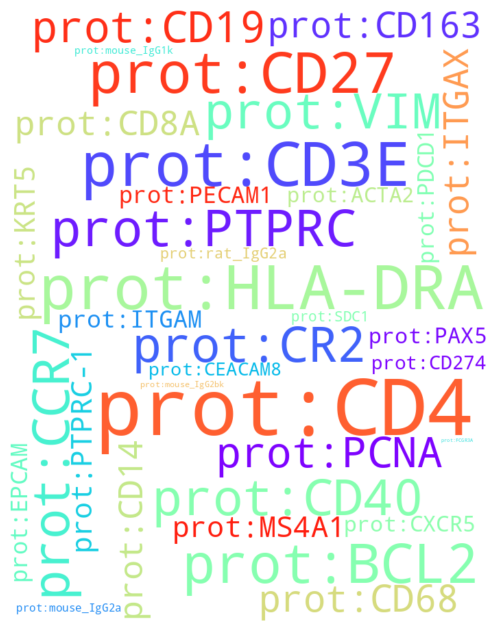

In [10]:
cloud = ' '.join(prot.var_names).replace('Ms.', '').replace('TCR', '').replace('.', '')


mean_expr = np.array(prot.X.mean(axis=0)).flatten()

freq_dict = {name.replace('Ms.', '').replace('TCR', '').replace('.', '').replace('Hu', '').replace('MsRt', ''): expr 
             for name, expr in zip(prot.var_names, mean_expr)}

wordcloud = WordCloud(width=700, height=900, 
        background_color='white', colormap='rainbow').generate_from_frequencies(freq_dict)

# Display the word cloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [11]:
from muon import prot as pt
prot.layers['counts'] = prot.X
pt.pp.dsb(
    mdata, 
    mdata_raw, 
    empty_counts_range=(1.5, 2.8), 
    isotype_controls=isotypes, 
    random_state=1
)

In [12]:
rna = mdata.mod['rna']
mask = np.intersect1d(rna.obs_names, prot.obs_names)
rna

AnnData object with n_obs × n_vars = 4194 × 18085
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'

In [13]:
rna.var['MT'] = rna.var_names.str.startswith('rna:MT-')
sc.pp.calculate_qc_metrics(rna, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'isotype_control' as categorical
... storing 'normalized' as categorical
... storing 'pattern' as categorical
... storing 'read' as categorical
... storing 'secondary_name' as categorical
... storing 'sequence' as categorical


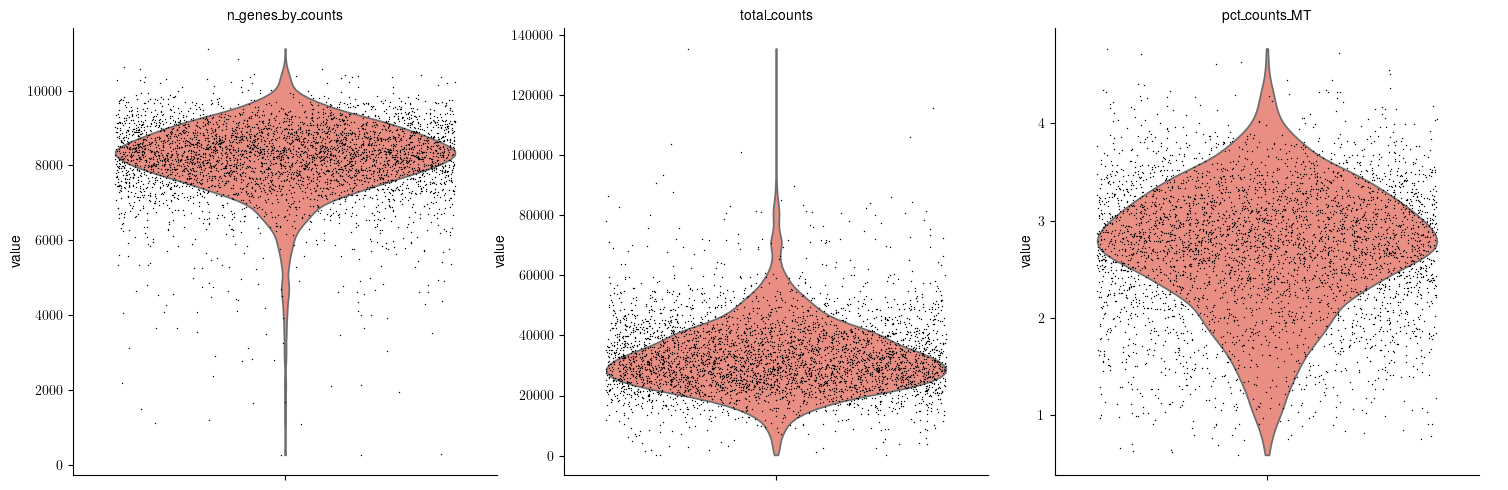

In [14]:
sc.pl.violin(
    rna,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'],
    jitter=0.4,
    multi_panel=True,
    color='salmon',
)

In [15]:
rna.var_names = rna.var_names.str.replace('rna:', '')

In [16]:
mu.pp.filter_var(rna, 'n_cells_by_counts', lambda x: x >= 3)
# mu.pp.filter_obs(rna, 'n_genes_by_counts', lambda x: (x >= 100) & (x < 5000))
# mu.pp.filter_obs(rna, 'total_counts', lambda x: (x > 1500) & (x < 15000))
mu.pp.filter_obs(rna, 'pct_counts_MT', lambda x: x < 20)

In [17]:
rna.layers['raw'] = rna.X.copy()

In [18]:
rna.layers['raw'].max()

21025.0

In [24]:
%%capture

spatial_xy = sc.read_visium(path='/Users/koush/Downloads/GEX_PEX/').obsm['spatial']
spatial_uns = sc.read_visium(path='/Users/koush/Downloads/GEX_PEX/').uns['spatial']
cell_type = pd.read_csv('cell2location_cell_types.csv', index_col=0)

In [25]:
rna.obs = rna.obs.join(cell_type)
prot.obs = prot.obs.join(cell_type)

In [26]:
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.tl.pca(rna, svd_solver='arpack')

In [27]:
rna.obsm['spatial'] = spatial_xy
prot.obsm['spatial'] = spatial_xy
rna.uns['spatial'] = spatial_uns
prot.uns['spatial'] = spatial_uns

... storing 'cell_type' as categorical


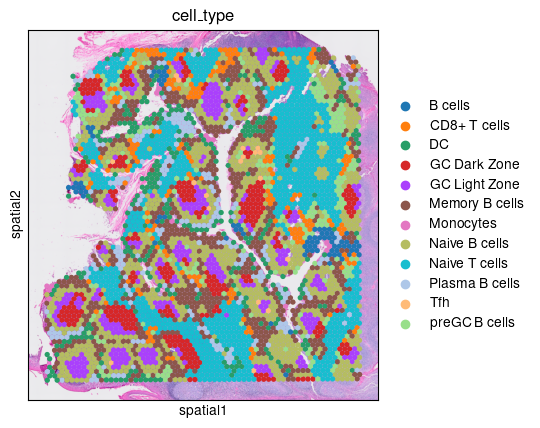

In [28]:
sc.pl.spatial(rna, color='cell_type', s=10)

In [29]:
sc.pp.neighbors(rna, use_rep='X_pca')
sc.tl.umap(rna, min_dist=0.9)

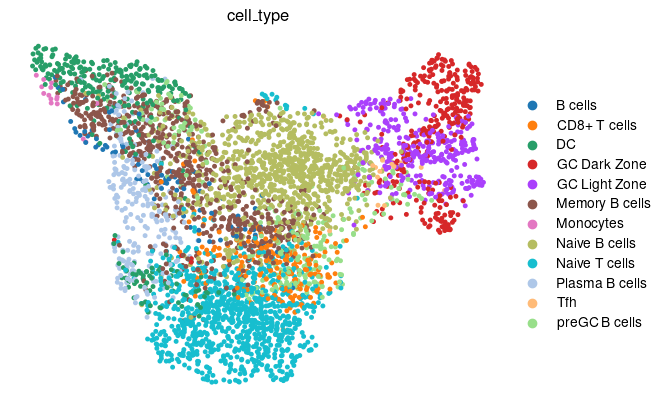

In [30]:
sc.pl.umap(rna, color='cell_type', s=50, frameon=False)

In [31]:
import commot as ct
import sys
sys.path.append('../../src')
sys.path.append('..')

from spaceoracle.tools.network import expand_paired_interactions

df_ligrec = ct.pp.ligand_receptor_database(
        database='CellChat', 
        species='human', 
        signaling_type=None
    )
            
df_ligrec.columns = ['ligand', 'receptor', 'pathway', 'signaling']
df_ligrec = expand_paired_interactions(df_ligrec)

extra_genes = np.unique(['FOXO1', 'BATF', 'BACH2', 'PRDM1', 'BCL6', 'FOXP3', 'SATB1', 'ID2', 'PAX5', 
    'CXCR4', 'CD83', 'CD86', 'AICDA', 'BCL2A1', 'BCL2', 'LMO2', 'CXCL13', 
    'CD80', 'TRAF3', 'CCL19', 'CCR7', 'CCL21', 'CD40LG', 'CD40', 'IRF4', 'IRF8', 
    'ITGA5', 'ITGB1', 'ITGAM', 'ITGB2', 'CCR6', 'CD19', 'LGALS9',
    'BCL2', 'IL2', 'IL4', 'CD83', 'CD86', 'SDF4', 'SDF2', 'SDF2L1', 
    'S1PR1', 'BMS1P14', 'S1PR3', 'S1PR4', 'S1PR2', 'EBI3', 'CD28', 
    'MICOS10', 'ICOS', 'MICOS13', 'ICOSLG', 'PDCD11', 'PDCD1', 'CD274', 
    'PDCD1LG2', 'TICAM2', 'ICAM2', 'TICAM1', 'EPCAM', 'ICAM1', 'ICAM3', 
    'VCAM1', 'CXCR4', 'CXCR5',  'CXCL13', 'CXCL14', 'CXCL12', 'CR2', 'NFKBIZ', 
    'NFKB1', 'NFKBIL1', 'NFKBIE', 'NFKB2', 'NFKBIA', 'NFKBID', 'NFKBIB', 
    'IL6R', 'IL6ST', 'EGR1', 'EGR3', 'EGR2', 'GATA3', 'TBX21', 'STAT3', 
    'STAT1', 'STAT4', 'STAT6', 'IL4', 'IL6ST', 'IL6', 'IL17A', 'CCR4', 'CCL5'])

len(extra_genes)

87

In [32]:
prot.var_names.str[5:]

Index(['CD163', 'CR2', 'PCNA', 'VIM', 'KRT5', 'CD68', 'CEACAM8', 'PTPRC',
       'HLA-DRA', 'PAX5', 'SDC1', 'PTPRC-1', 'CD8A', 'BCL2', 'mouse_IgG2a',
       'mouse_IgG1k', 'mouse_IgG2bk', 'rat_IgG2a', 'CD19', 'PDCD1', 'ACTA2',
       'FCGR3A', 'ITGAX', 'CXCR5', 'EPCAM', 'MS4A1', 'CD3E', 'CD14', 'CD40',
       'PECAM1', 'CD4', 'ITGAM', 'CD27', 'CCR7', 'CD274'],
      dtype='object')

In [33]:
df_ligrec[(df_ligrec.ligand.isin(prot.var_names.str[5:])) | (df_ligrec.receptor.isin(prot.var_names.str[5:]))]

,ligand,receptor,pathway,signaling
645,CCL19,CCR7,CCL,Secreted Signaling
646,CCL21,CCR7,CCL,Secreted Signaling
714,CXCL13,CXCR5,CXCL,Secreted Signaling
781,IL16,CD4,IL16,Secreted Signaling
823,CD70,CD27,CD70,Secreted Signaling
...,...,...,...,...
1887,CD274,PDCD1,PD-L1,Cell-Cell Contact
1888,PDCD1LG2,PDCD1,PDL2,Cell-Cell Contact
1889,PECAM1,PECAM1,PECAM1,Cell-Cell Contact
1930,THY1,ITGAM,THY1,Cell-Cell Contact


In [34]:
ptmp = prot.copy()

In [35]:
ptmp.X = ptmp.X.clip(0)

In [36]:
sc.pp.log1p(ptmp)

In [37]:
ptmp.X.min(), ptmp.X.max()

(0.0, 4.4023414)

In [38]:
np.setdiff1d(['rna:' + i for i in pd.read_csv('antibody_panel.csv').name], rna.var_names)

array(['rna:ACTA2', 'rna:BCL2', 'rna:CCR7', 'rna:CD14', 'rna:CD163',
       'rna:CD19', 'rna:CD27', 'rna:CD274', 'rna:CD3E', 'rna:CD4',
       'rna:CD40', 'rna:CD68', 'rna:CD8A', 'rna:CEACAM8', 'rna:CR2',
       'rna:CXCR5', 'rna:EPCAM', 'rna:FCGR3A', 'rna:HLA-DRA', 'rna:ITGAM',
       'rna:ITGAX', 'rna:KRT5', 'rna:MS4A1', 'rna:PAX5', 'rna:PCNA',
       'rna:PDCD1', 'rna:PECAM1', 'rna:PTPRC_1', 'rna:PTPRC_2',
       'rna:SDC1', 'rna:VIM'], dtype='<U11')

In [39]:
np.setdiff1d(['rna:' + i for i in pd.read_csv('antibody_panel.csv').secondary_name], rna.var_names)

array(['rna:BCL2', 'rna:CD11b', 'rna:CD11c', 'rna:CD138', 'rna:CD14',
       'rna:CD16', 'rna:CD163', 'rna:CD19', 'rna:CD197', 'rna:CD20',
       'rna:CD21', 'rna:CD27', 'rna:CD31', 'rna:CD3E', 'rna:CD4',
       'rna:CD40', 'rna:CD45RA', 'rna:CD45RO', 'rna:CD66b', 'rna:CD68',
       'rna:CD8A', 'rna:CXCR5', 'rna:EPCAM', 'rna:HLA-DR', 'rna:PAX5',
       'rna:PCNA', 'rna:PD1', 'rna:PDL1', 'rna:PanCK', 'rna:Vimentin',
       'rna:alphaSMA'], dtype='<U12')

In [42]:
rna.var_names

Index(['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15',
       'AGRN', 'RNF223', 'C1orf159',
       ...
       'MT-ND2', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=18049)

In [44]:
shared = np.intersect1d(rna.var_names, ptmp.var_names.str.replace('prot:', ''))
len(shared)

29

In [45]:
rna.to_df().loc[:, shared].sum()

ACTA2        496.317566
BCL2        1892.721191
CCR7        2565.535156
CD14        1361.003174
CD163        285.924561
CD19        3908.253174
CD27        4135.578125
CD274       1243.394775
CD3E        2957.067383
CD4         4527.140137
CD40        4327.765625
CD68        2200.184326
CD8A         804.524719
CEACAM8       58.425278
CR2         3148.429932
CXCR5       2412.801270
EPCAM        314.924500
FCGR3A       163.260254
ITGAM       1022.310364
ITGAX       3507.880859
KRT5        2969.684814
MS4A1      12430.770508
PAX5        5035.092773
PCNA        1712.069946
PDCD1       1016.767761
PECAM1      3923.121582
PTPRC       3815.480713
SDC1        1228.972778
VIM        13399.628906
dtype: float32

In [48]:
shared

array(['ACTA2', 'BCL2', 'CCR7', 'CD14', 'CD163', 'CD19', 'CD27', 'CD274',
       'CD3E', 'CD4', 'CD40', 'CD68', 'CD8A', 'CEACAM8', 'CR2', 'CXCR5',
       'EPCAM', 'FCGR3A', 'ITGAM', 'ITGAX', 'KRT5', 'MS4A1', 'PAX5',
       'PCNA', 'PDCD1', 'PECAM1', 'PTPRC', 'SDC1', 'VIM'], dtype=object)

In [49]:
rna_df = rna.to_df().copy()
rna_df.loc[:, shared] = ptmp.to_df().loc[:, ['prot:'+i for i in shared]].values

In [50]:
rna.to_df().sum().sum()

21679840.0

In [51]:
rna.X = rna_df.values.copy()

In [52]:
rna.to_df().sum().sum()

21927516.0

In [53]:
adata = rna.copy()

In [54]:
adata = adata[:, ~adata.var_names.str.contains('RIK')]
adata = adata[:, ~adata.var_names.str.contains(r'^HB\w+-\w+$')]
adata = adata[:, ~adata.var_names.str.contains('HP')]
adata = adata[:, ~adata.var_names.str.startswith('RP')]
adata = adata[:, ~adata.var_names.str.startswith('AA')]
adata = adata[:, ~adata.var_names.str.startswith('AB')]
adata = adata[:, ~adata.var_names.str.startswith('AC')]
adata = adata[:, ~adata.var_names.str.startswith('GM')]
adata = adata[:, ~adata.var_names.str.startswith('MIR')]
adata = adata[:, ~adata.var_names.str.startswith('TTT')]
adata = adata[:, ~adata.var_names.str.startswith('LINC')]
adata = adata[:, ~adata.var_names.str.endswith('-AS1')]

In [55]:
n_top_genes = 3500
min_cells = 10
min_counts = 50

In [59]:
adata.var_names_make_unique()
adata.var["MT"] = adata.var_names.str.startswith("MT-")

In [60]:
adata.var["MT"].any()

True

In [61]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["MT"], inplace=True)
sc.pp.filter_cells(adata, min_counts=min_counts)
adata = adata[adata.obs["pct_counts_MT"] < 10].copy()
adata = adata[:, ~adata.var["MT"]]

sc.pp.filter_genes(adata, min_cells=min_cells)
adata.layers["normalized_count"] = adata.to_df().values.copy()

ligand_receptor_genes = np.intersect1d(
    adata.var_names, 
    df_ligrec.ligand.unique().tolist()+df_ligrec.receptor.unique().tolist())

lr_df = adata.to_df(layer='normalized_count').join(
    adata.obs.cell_type).groupby('cell_type').mean()[
        ligand_receptor_genes].mean().sort_values(ascending=False).to_frame().reset_index()
lr_df.columns = ['genes', 'expr']

lr_df['mean_expr'] = lr_df['genes'].apply(lambda x: adata.to_df(layer='normalized_count')[x].mean())
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=n_top_genes, inplace=True)

adata = adata[:, (
    adata.var.highly_variable | adata.var_names.isin(
        list(extra_genes)+lr_df.query('expr > 0.005').genes.to_list()))]

adata

View of AnnData object with n_obs × n_vars = 4194 × 4053
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'cell_type', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'log1p_total_counts_MT', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'MT', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_mean_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'log1p', 'pca', 'spatial', 'cell_type_colors', 'neighbors', 'umap', 'hvg'
    obsm: 'X_pca', 'spatial', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'normalized_count'
    obsp: 'distances', 'connectivities'

In [62]:
for key in ['n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_MT',
       'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts']:
    if key in adata.obs.keys():
        adata.obs.pop(key)

for key in ['MT', 'RP', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts',
       'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts',
       'n_cells', 'highly_variable', 'means', 'dispersions',
       'dispersions_norm']:
    if key in adata.var.keys():
        adata.var.pop(key)

del adata.uns

In [63]:
from spaceoracle.tools.network import encode_labels

In [64]:
adata.obs['cell_type'] = adata.obs['cell_type'].replace('Monocytes', 'DC')

In [65]:
adata.obs['cell_type'] = adata.obs['cell_type'].astype('category')
adata.obs['cell_type_int'] = adata.obs['cell_type'].apply(
    lambda x: encode_labels(adata.obs['cell_type'], reverse_dict=True)[x])

In [66]:
adata

AnnData object with n_obs × n_vars = 4194 × 4053
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'highly_variable_rank', 'variances', 'variances_norm'
    obsm: 'X_pca', 'spatial', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'normalized_count'
    obsp: 'distances', 'connectivities'

In [67]:
from spaceoracle.oracles import BaseTravLR

In [68]:
adata.obs['cell_type'].value_counts()

cell_type
Naive T cells     915
Naive B cells     867
Memory B cells    657
GC Light Zone     327
DC                326
GC Dark Zone      318
preGC B cells     246
Plasma B cells    235
CD8+ T cells      200
B cells            85
Tfh                18
Name: count, dtype: int64

In [69]:
'PAX5' in adata.var_names

True

In [70]:
BaseTravLR.impute_clusterwise(adata)

In [71]:
adata

AnnData object with n_obs × n_vars = 4194 × 4053
    obs: 'cell_type', 'cell_type_int'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence', 'highly_variable_rank', 'variances', 'variances_norm'
    obsm: 'X_pca', 'spatial', 'X_umap'
    varm: 'PCs'
    layers: 'raw', 'normalized_count', 'imputed_count'
    obsp: 'distances', 'connectivities'

In [72]:
adata.write_h5ad('/Volumes/SSD/training_data/human_tonsil_proteomics.h5ad')